In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from cadet import Cadet

In [2]:
# macOS installation path
Cadet.cadet_path = '/Users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

In [3]:
# Windows installation path
# Cadet.cadet_path = 'C:/Users/hoang/miniconda3/envs/cadet-env/bin/cadet-cli.exe'

In [4]:
from addict import Dict
import json
from pathlib import Path

In [5]:
base_dir = Path('./').absolute()

match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results'

In [6]:
def get_cadet_template(n_units=3, split_components_data=False):
    cadet_template = Cadet()
    
    cadet_template.root.input.model.nunits = n_units
    
    # Store solution
    cadet_template.root.input['return'].split_components_data = split_components_data
    cadet_template.root.input['return'].split_ports_data = 0
    cadet_template.root.input['return'].unit_000.write_solution_inlet = 1
    cadet_template.root.input['return'].unit_000.write_solution_outlet = 1
    cadet_template.root.input['return'].unit_000.write_solution_bulk = 1
    cadet_template.root.input['return'].unit_000.write_solution_particle = 1
    cadet_template.root.input['return'].unit_000.write_solution_solid = 1
    cadet_template.root.input['return'].unit_000.write_solution_flux = 1
    cadet_template.root.input['return'].unit_000.write_solution_volume = 1
    cadet_template.root.input['return'].unit_000.write_coordinates = 1
    cadet_template.root.input['return'].unit_000.write_sens_outlet = 1
    
    for unit in range(n_units):
        cadet_template.root.input['return']['unit_{0:03d}'.format(unit)] = cadet_template.root.input['return'].unit_000
        
    # Tolerances for the time integrator
    cadet_template.root.input.solver.time_integrator.abstol = 1e-6
    cadet_template.root.input.solver.time_integrator.algtol = 1e-10
    cadet_template.root.input.solver.time_integrator.reltol = 1e-6
    cadet_template.root.input.solver.time_integrator.init_step_size = 1e-6
    cadet_template.root.input.solver.time_integrator.max_steps = 1000000
    
    # Solver settings
    cadet_template.root.input.model.solver.gs_type = 1
    cadet_template.root.input.model.solver.max_krylov = 0
    cadet_template.root.input.model.solver.max_restarts = 10
    cadet_template.root.input.model.solver.schur_safety = 1e-8

    # Run the simulation on single thread
    cadet_template.root.input.solver.nthreads = 1
    
    return cadet_template

In [7]:
def set_discretization(model, n_bound=None, n_col=20, n_par_types=1):
    columns = {'GENERAL_RATE_MODEL', 'LUMPED_RATE_MODEL_WITH_PORES', 'LUMPED_RATE_MODEL_WITHOUT_PORES'}
    
    
    for unit_name, unit in model.root.input.model.items():
        if 'unit_' in unit_name and unit.unit_type in columns:
            unit.discretization.ncol = n_col
            unit.discretization.npar = 5
            unit.discretization.npartype = n_par_types
            
            if n_bound is None:
                n_bound = unit.ncomp*[0]
            unit.discretization.nbound = n_bound
            
            unit.discretization.par_disc_type = 'EQUIDISTANT_PAR'
            unit.discretization.use_analytic_jacobian = 1
            unit.discretization.reconstruction = 'WENO'
            unit.discretization.gs_type = 1
            unit.discretization.max_krylov = 0
            unit.discretization.max_restarts = 10
            unit.discretization.schur_safety = 1.0e-8

            unit.discretization.weno.boundary_model = 0
            unit.discretization.weno.weno_eps = 1e-10
            unit.discretization.weno.weno_order = 3

In [8]:
def create_dextran_model():

    dextran_model = get_cadet_template(n_units=3, split_components_data=True)

    # INLET
    dextran_model.root.input.model.unit_000.unit_type = 'INLET'
    dextran_model.root.input.model.unit_000.ncomp = 1
    dextran_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

    # Column
    dextran_model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'
    dextran_model.root.input.model.unit_001.ncomp = 1
    
    dextran_model.root.input.model.unit_001.col_length = 0.25
    dextran_model.root.input.model.unit_001.cross_section_area = 1e-4
    dextran_model.root.input.model.unit_001.col_porosity = 0.37
    dextran_model.root.input.model.unit_001.par_porosity = 0.33
    dextran_model.root.input.model.unit_001.par_radius = 4.5e-5

    dextran_model.root.input.model.unit_001.col_dispersion = 2.0e-7
    dextran_model.root.input.model.unit_001.film_diffusion = [0.0,]
    
    dextran_model.root.input.model.unit_001.adsorption_model = 'NONE'
    
    dextran_model.root.input.model.unit_001.init_c = [0.0,]

    set_discretization(dextran_model, n_col=100)
            
    ## Outlet
    dextran_model.root.input.model.unit_002.ncomp = 1
    dextran_model.root.input.model.unit_002.unit_type = 'OUTLET'
    
    # Sections and connections
    dextran_model.root.input.solver.sections.nsec = 2
    dextran_model.root.input.solver.sections.section_times = [0.0, 50.0, 600.0]
    dextran_model.root.input.solver.sections.section_continuity = [0,]
    
    ## Inlet Profile
    dextran_model.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
    dextran_model.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
    
    ## Switches
    dextran_model.root.input.model.connections.nswitches = 1
    dextran_model.root.input.model.connections.switch_000.section = 0
    dextran_model.root.input.model.connections.switch_000.connections = [
        0, 1, -1, -1, 2.88e-8,
        1, 2, -1, -1, 2.88e-8
    ]

    #set the times that the simulator writes out data for
    dextran_model.root.input.solver.user_solution_times = np.linspace(0, 600, 601)

    return dextran_model

def plot_dextran_model(model):
    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_001.solution_outlet_comp_000
    plt.plot(time, c)
    plt.title('Column (Outlet)')
    plt.xlabel('$time~/~min$')
    plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
    plt.show()

In [9]:
def run_simulation(cadet, file_name=None):
    if file_name is None:
        f = next(tempfile._get_candidate_names())
        cadet.filename = os.path.join(tempfile.tempdir, f + '.h5')
    else:
        cadet.filename = file_name
    # save the simulation
    cadet.save()

    # run the simulation and load results
    data = cadet.run()
    cadet.load()
    
    # Remove files 
    if file_name is None:
        os.remove(os.path.join(tempfile.tempdir, f + '.h5'))

    # Raise error if simulation fails
    if data.returncode == 0:
        print("Simulation completed successfully")
    else:
        print(data)
        raise Exception("Simulation failed")

In [10]:
dextran_model = create_dextran_model()
run_simulation(dextran_model, 'dextran_reference.h5')

Simulation completed successfully


In [11]:
parameter1 = Dict()
parameter1.location = '/input/model/unit_001/COL_DISPERSION'
parameter1.min = 1e-10
parameter1.max = 1e-6
parameter1.component = -1
parameter1.bound = -1
parameter1.transform = 'null'

parameter2 = Dict()
parameter2.location = '/input/model/unit_001/COL_POROSITY'
parameter2.min = 0.2
parameter2.max = 0.7
parameter2.component = -1
parameter2.bound = -1
parameter2.transform = 'null'

match_config.parameters = [parameter1, parameter2]

In [12]:
experiment1 = Dict()
experiment1.name = 'dextran'
experiment1.csv = '../resources/dextran_experiment.csv'
experiment1.HDF5 = 'dextran_reference.h5'
experiment1.output_path = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'

match_config.experiments = [experiment1,]

In [13]:
feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'SSE'

experiment1.features = [feature1,]

In [14]:
match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

In [15]:
from CADETMatch.jupyter import Match

match_config_file = base_dir / 'dextran.json'

with open(match_config_file.as_posix(), 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_config_file)
match.start_sim()

/Users/hoangnguyen/conda-envs/cadet-env/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2022-10-30 21:28:57,246 match.py print_version 116 CADETMatch starting up version: 0.7.1

2022-10-30 21:28:57,247 match.py print_version 144 joblib version: 1.2.0 tested with 1.0.1

2022-10-30 21:28:57,247 match.py print_version 144 addict version: 2.4.0 tested with 2.2.1

2022-10-30 21:28:57,248 match.py print_version 144 corner version: 2.2.1 tested with 2.1.0

2022-10-30 21:28:57,249 match.py print_version 144 emcee version: 3.1.3 tested with 3.0.2

2022-10-30 21:28:57,249 match.py print_version 144 SALib version: 1.4.5 tested with 1.3.11

2022-10-30 21:28:57,250 match.py print_version 144 deap version: 1.3.3 tested with 1.3.1

2022-10-30 21:28:57,250 match.py print_version 144 psutil version: 5.9.2 tested with 5.8.0

2022-10-30 21:28:57,251 match.py print_version 144 numpy version: 1.23.3 tested with 1.20.1

2022-10-30 21:28:57,251 match.py print_version 144 openpyxl version: 3.0.10 tested with 3.0.7

2022-10-30 21:28:57,251 match.py print_version 144 scipy version: 1.9.1 tested wi

0

Corner plot in search space


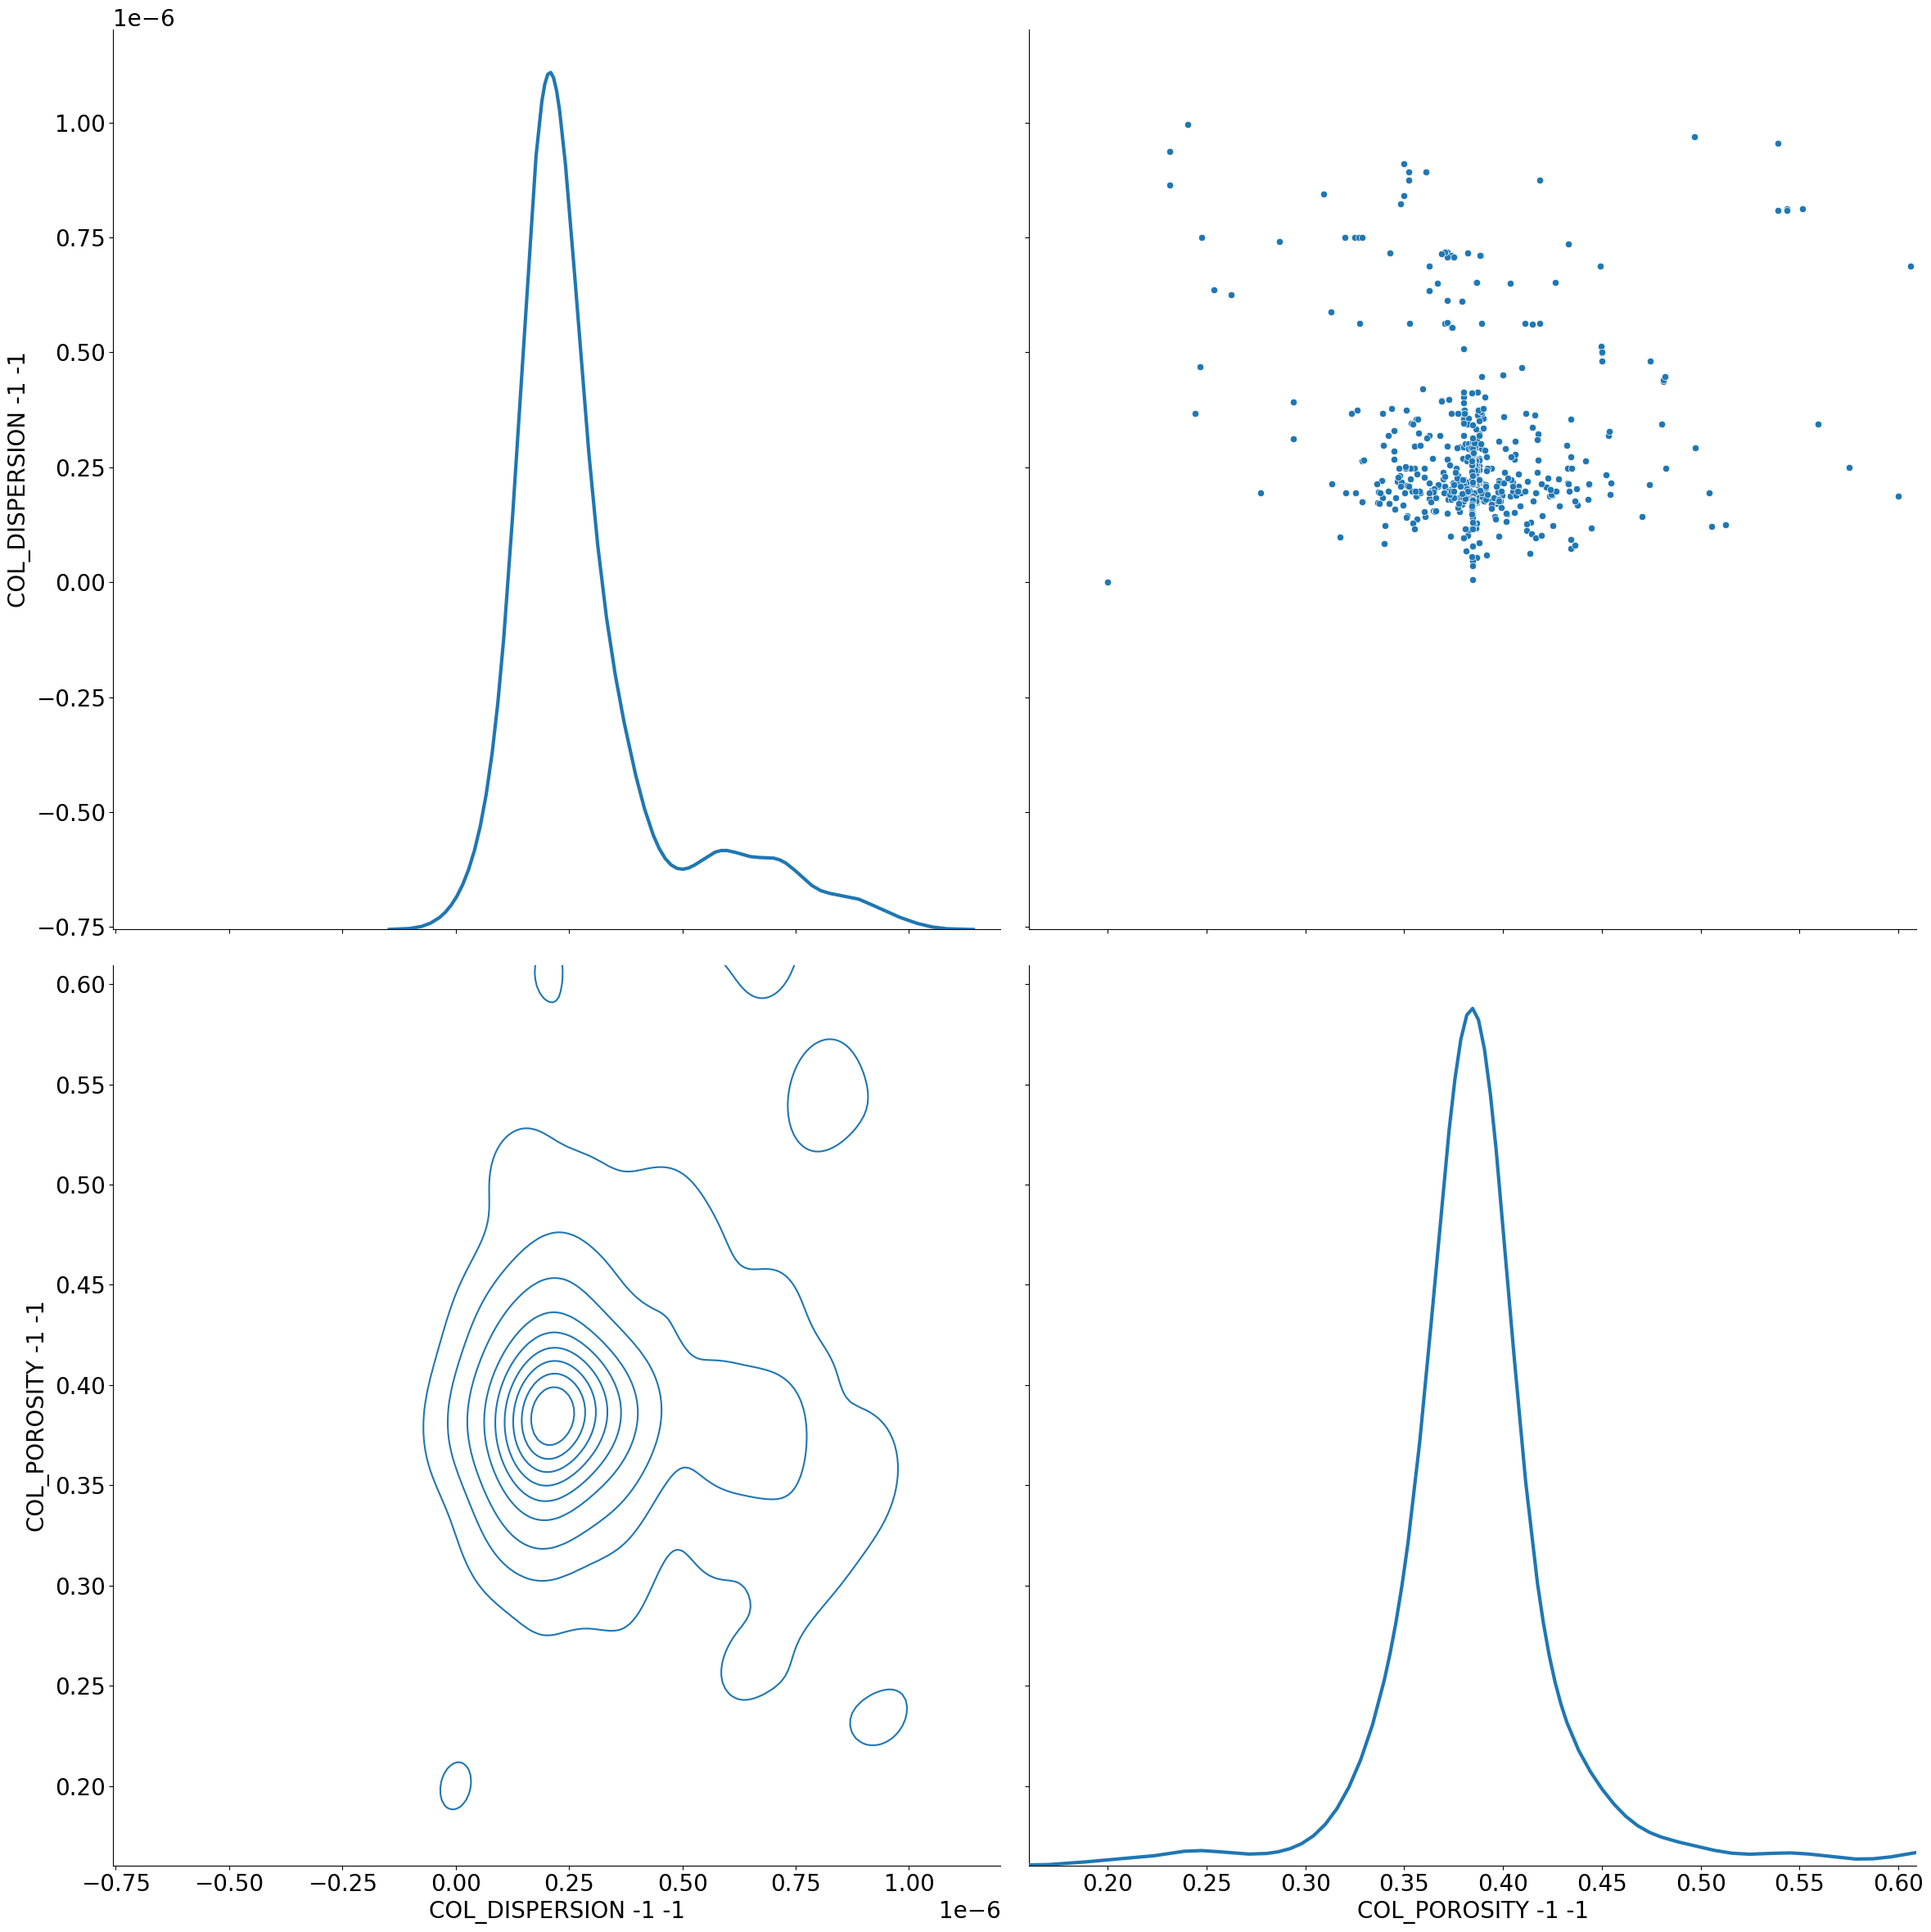

Corner plot in original space


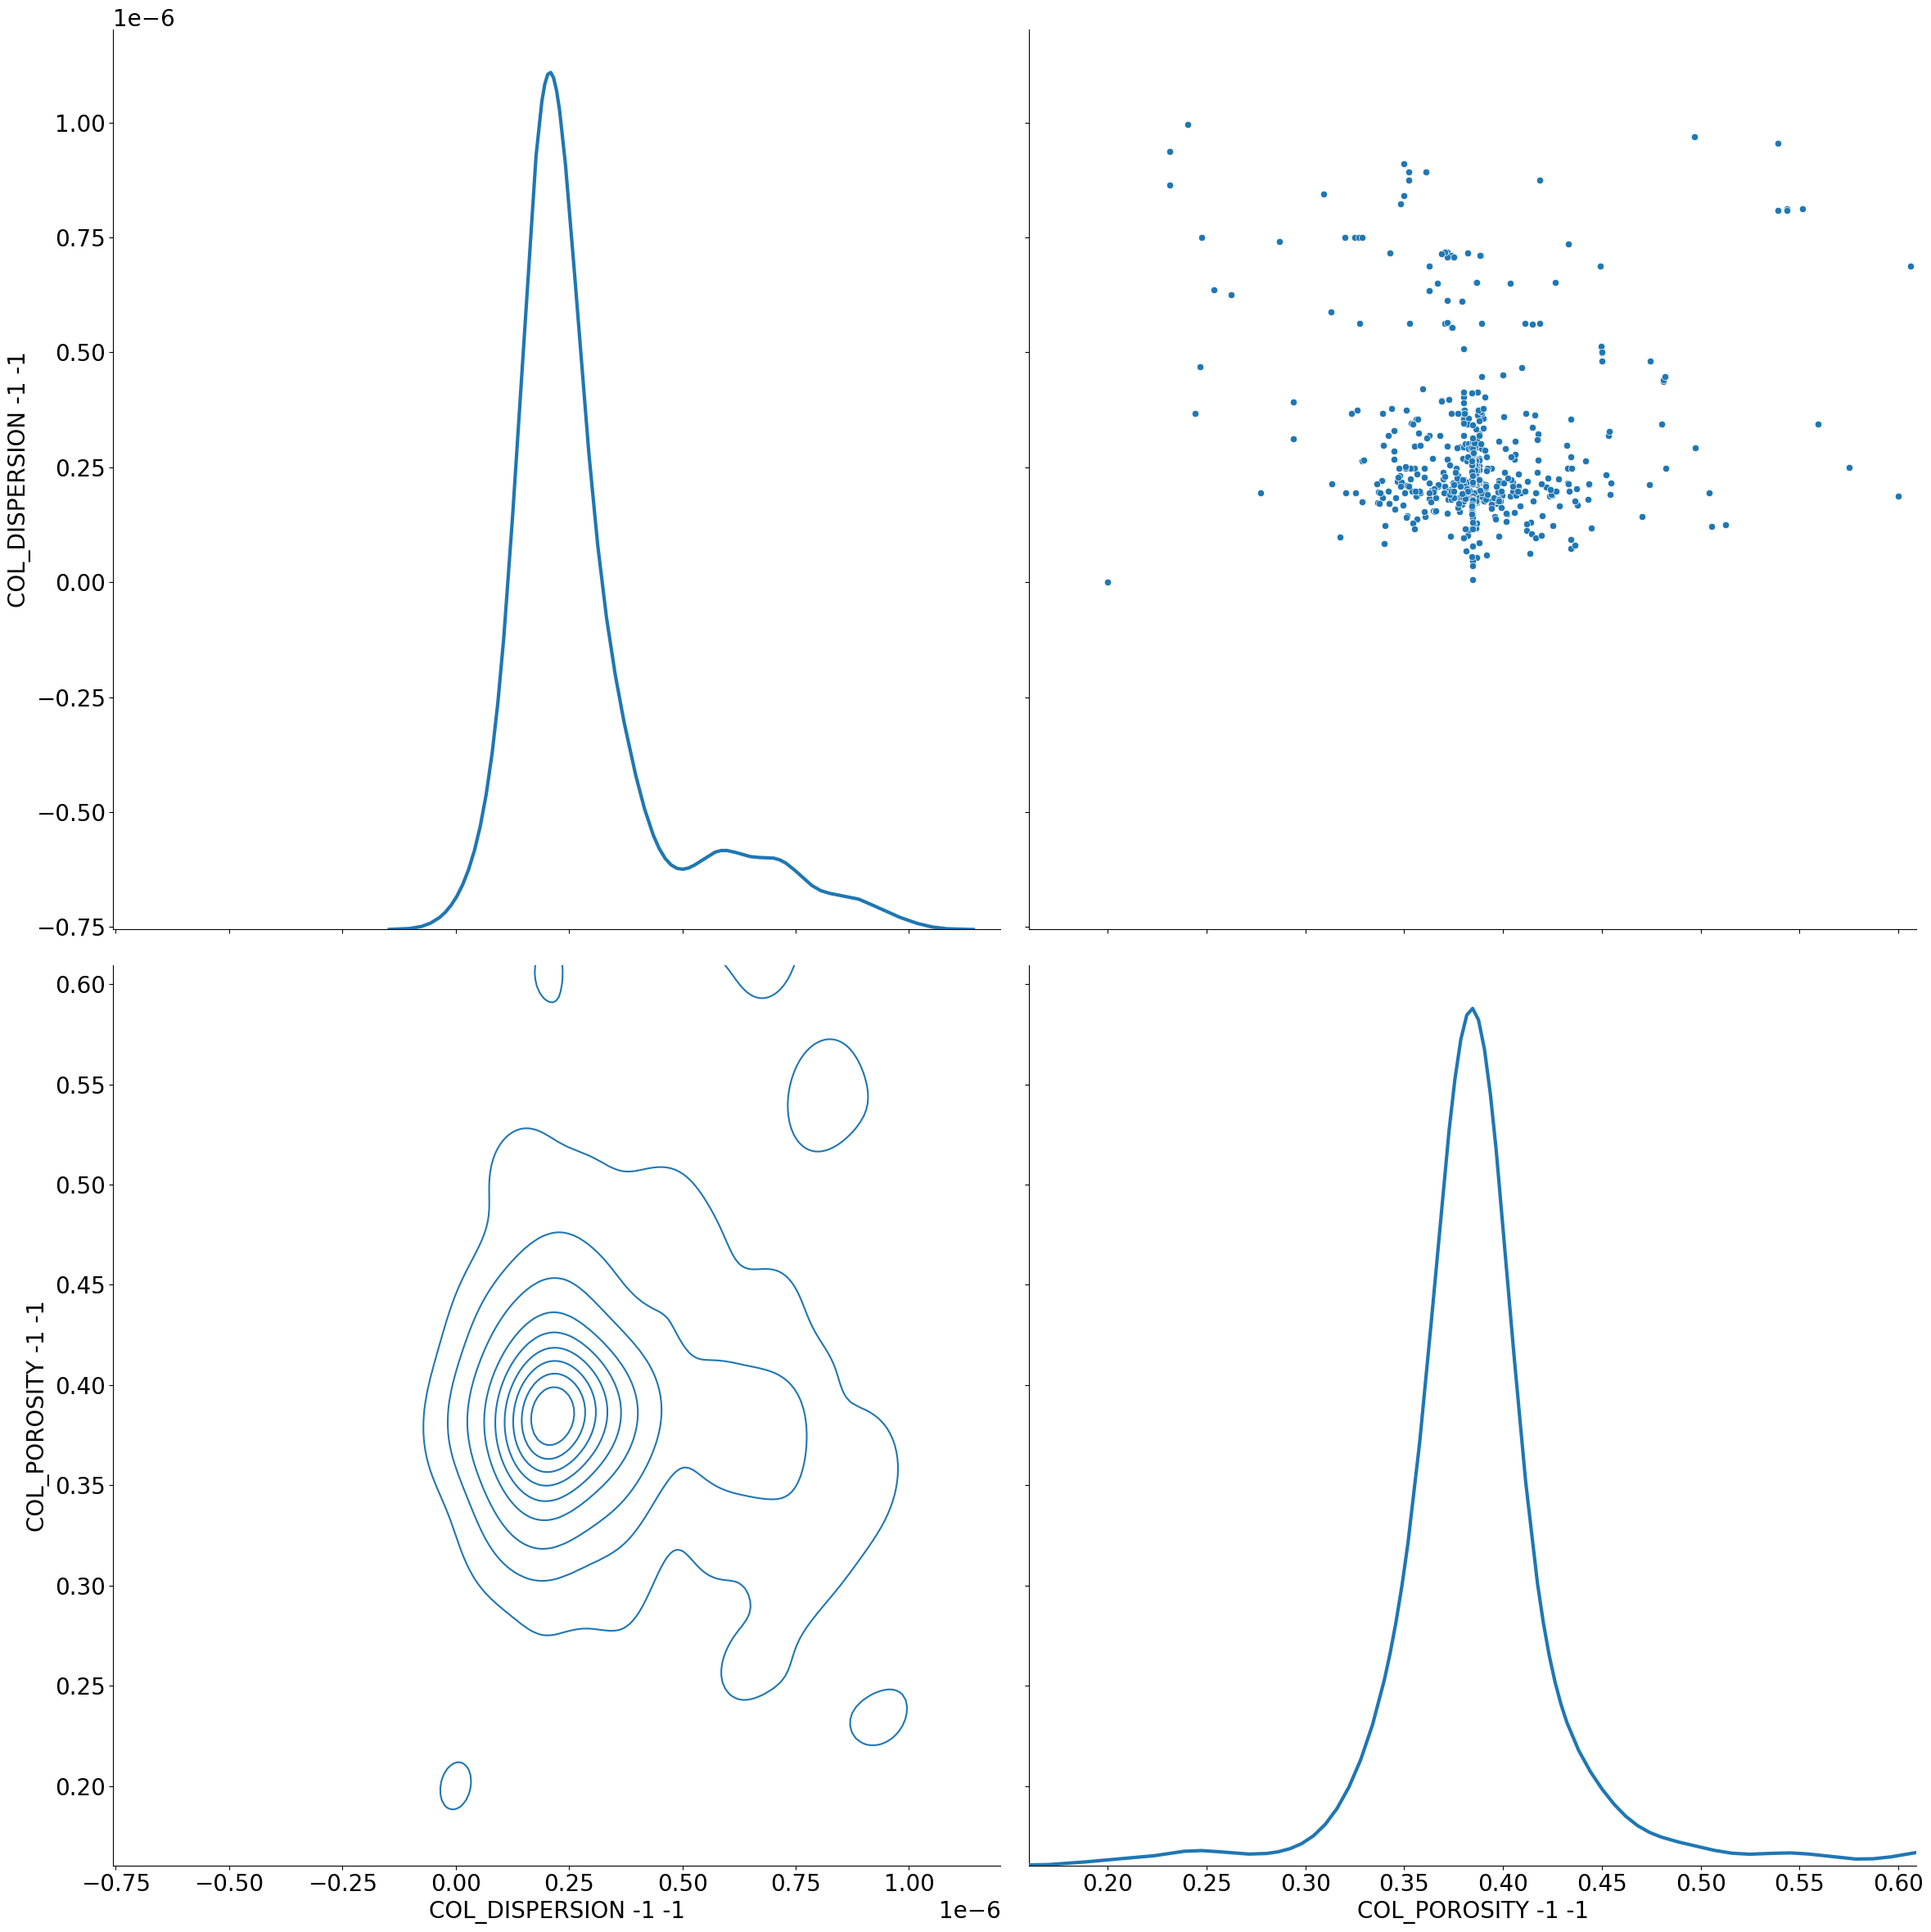

In [16]:
match.plot_corner()

Best item 3ab6812ed35758ec423f6d9e46e1617b for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,dextran_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE,RMSE
0,Sun Oct 30 21:29:19 2022,3ab6812ed35758ec423f6d9e46e1617b,GRAD,39260.622301,2.000000e-07,0.384315,8.933593e-26,8.933593e-26,8.933593e-26,8.933593e-26,8.933593e-26,1.398465e-14


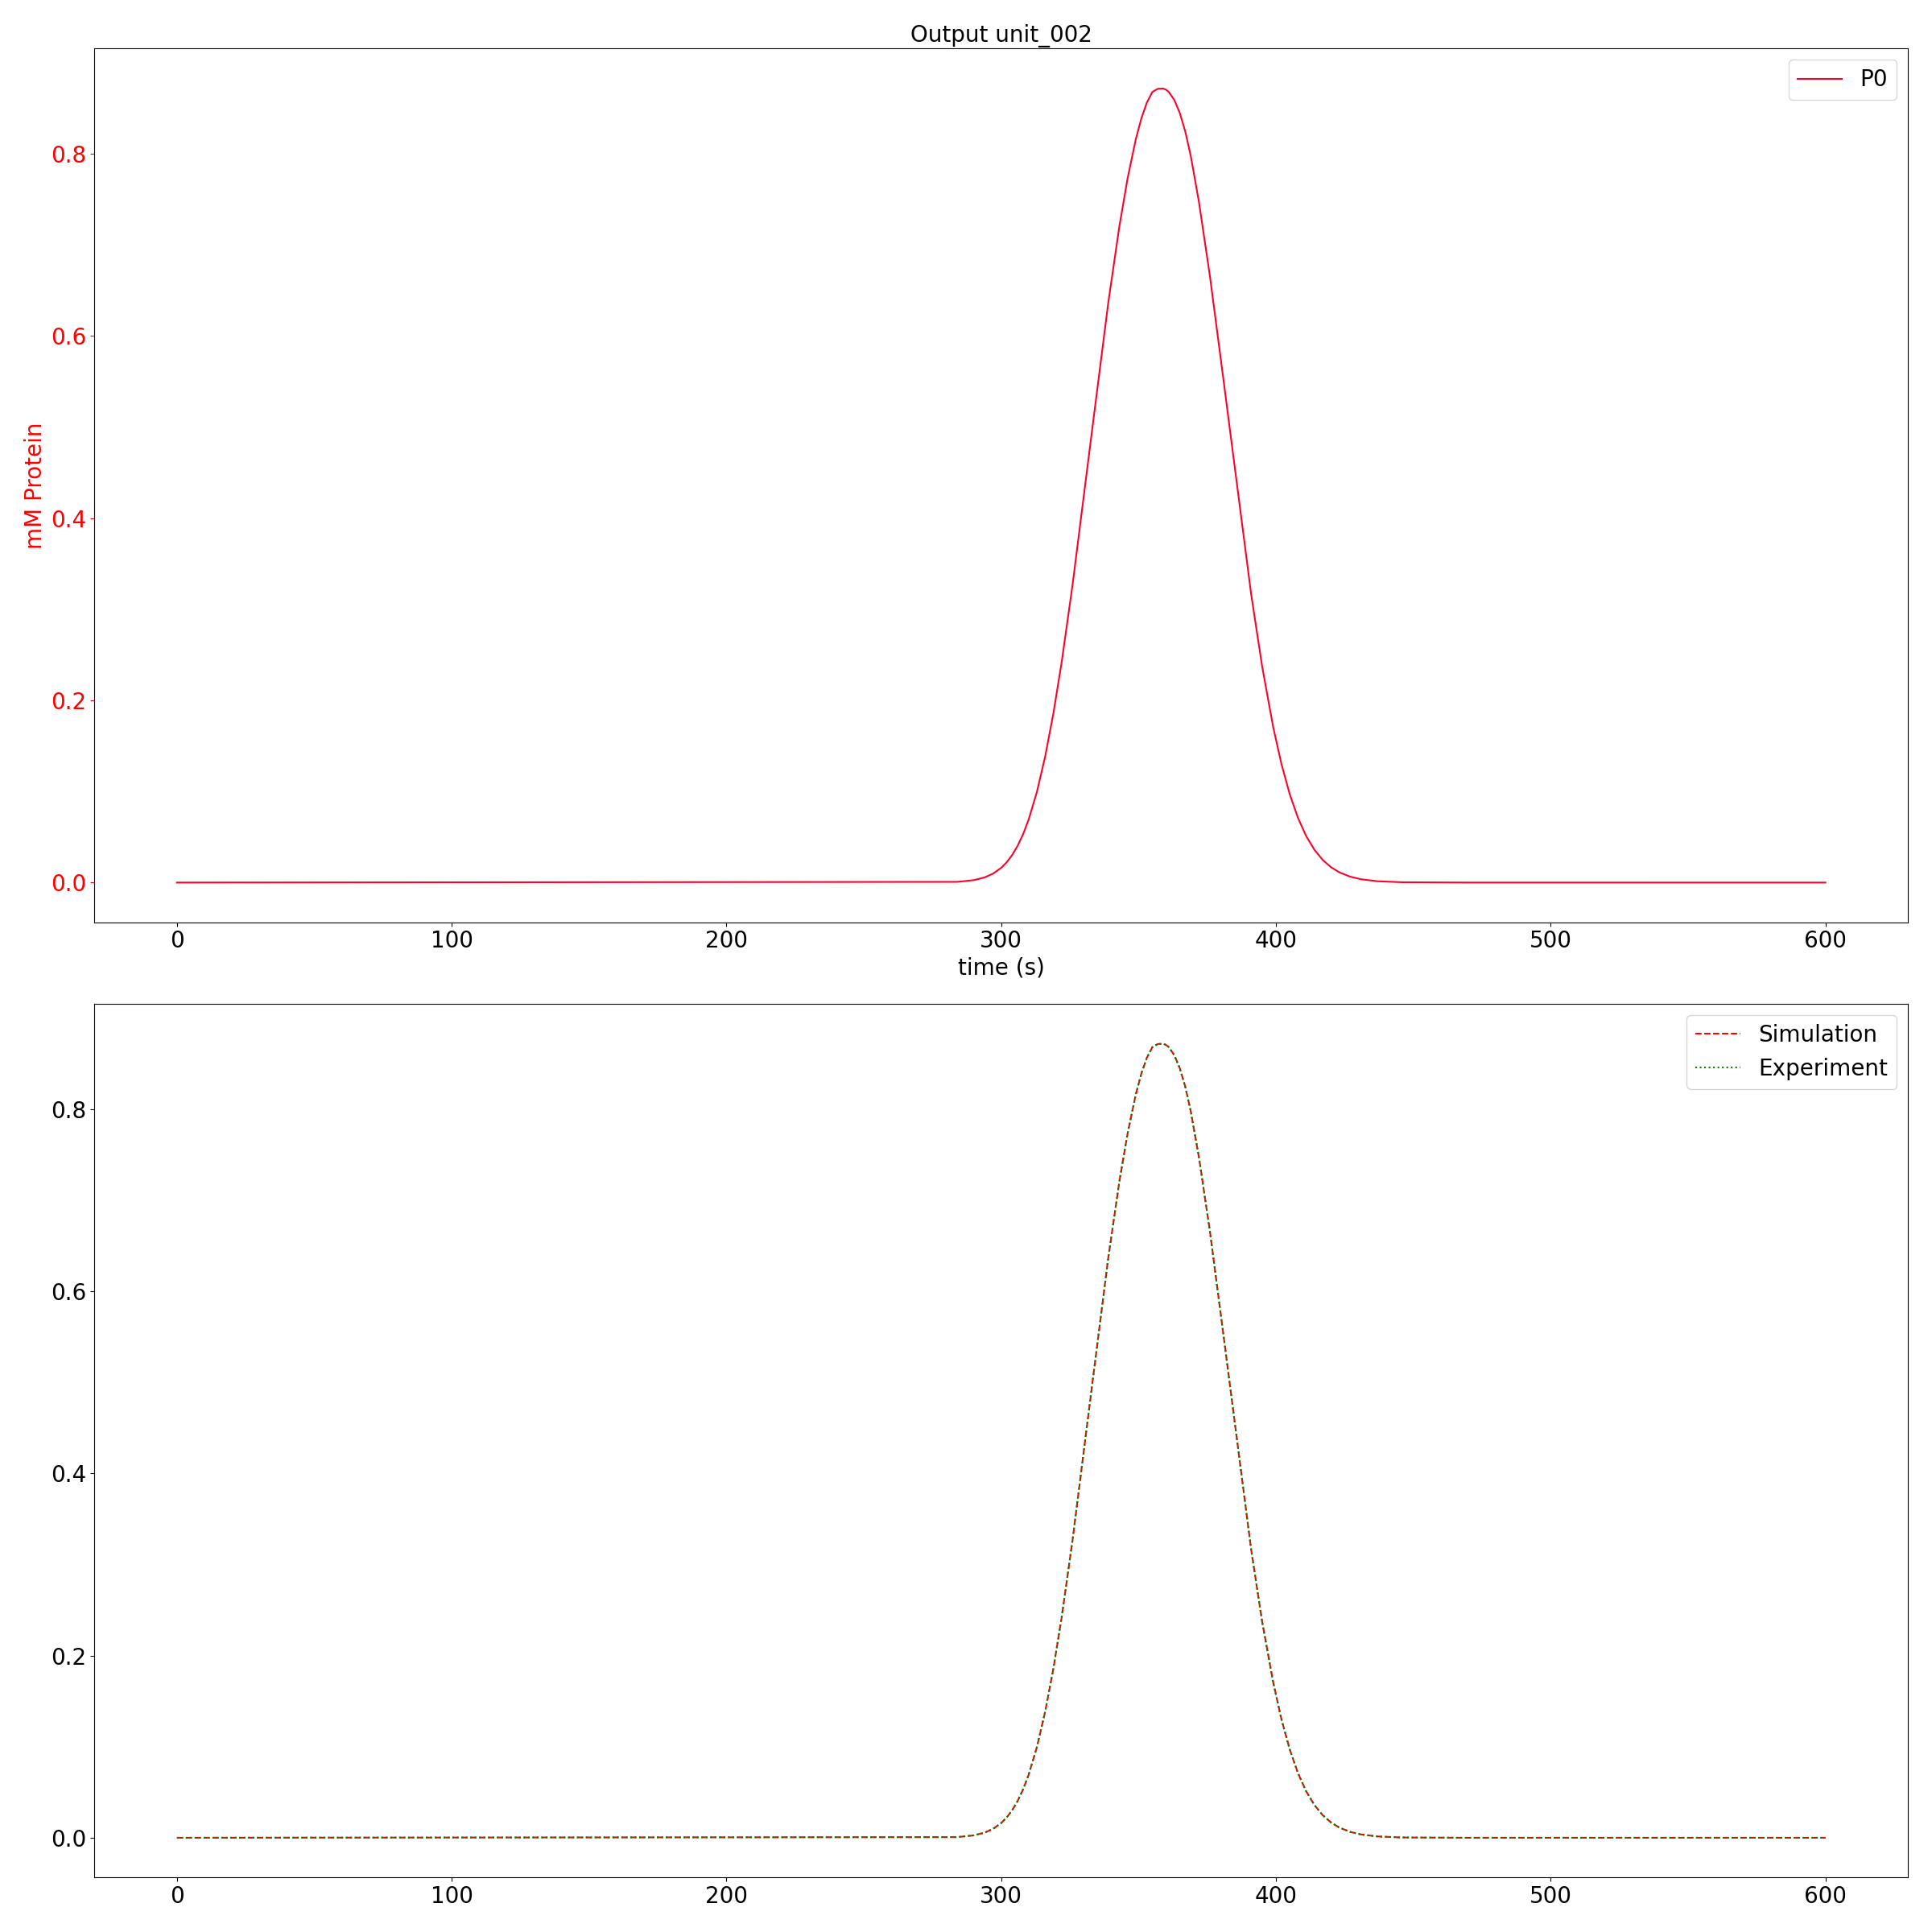

In [17]:
match.plot_best()

In [18]:
parameter1 = Dict()
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.component = -1
parameter1.bound = -1
parameter1.min = 1e-10
parameter1.max = 1e-6
parameter1.transform = 'auto'

parameter2 = Dict()
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.component = -1
parameter2.bound = -1
parameter2.min = 0.2
parameter2.max = 0.5
parameter2.transform = 'auto'

In [19]:
match = Dict(match_config)
match.CADETPath = Cadet.cadet_path
match.baseDir = base_dir.as_posix()
match.resultsDir = 'fit_grad'
match.searchMethod = 'NSGA3'

match.parameters = [parameter1, parameter2]

In [20]:
match_config_file = base_dir / 'dextran_auto.json'

with open(match_config_file.as_posix(), 'w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

match = Match(match_config_file)
match.start_sim()

/Users/hoangnguyen/conda-envs/cadet-env/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2022-10-30 21:29:33,739 match.py print_version 116 CADETMatch starting up version: 0.7.1

2022-10-30 21:29:33,741 match.py print_version 144 joblib version: 1.2.0 tested with 1.0.1

2022-10-30 21:29:33,741 match.py print_version 144 addict version: 2.4.0 tested with 2.2.1

2022-10-30 21:29:33,742 match.py print_version 144 corner version: 2.2.1 tested with 2.1.0

2022-10-30 21:29:33,742 match.py print_version 144 emcee version: 3.1.3 tested with 3.0.2

2022-10-30 21:29:33,747 match.py print_version 144 SALib version: 1.4.5 tested with 1.3.11

2022-10-30 21:29:33,748 match.py print_version 144 deap version: 1.3.3 tested with 1.3.1

2022-10-30 21:29:33,749 match.py print_version 144 psutil version: 5.9.2 tested with 5.8.0

2022-10-30 21:29:33,749 match.py print_version 144 numpy version: 1.23.3 tested with 1.20.1

2022-10-30 21:29:33,750 match.py print_version 144 openpyxl version: 3.0.10 tested with 3.0.7

2022-10-30 21:29:33,750 match.py print_version 144 scipy version: 1.9.1 tested wi

0

Corner plot in search space


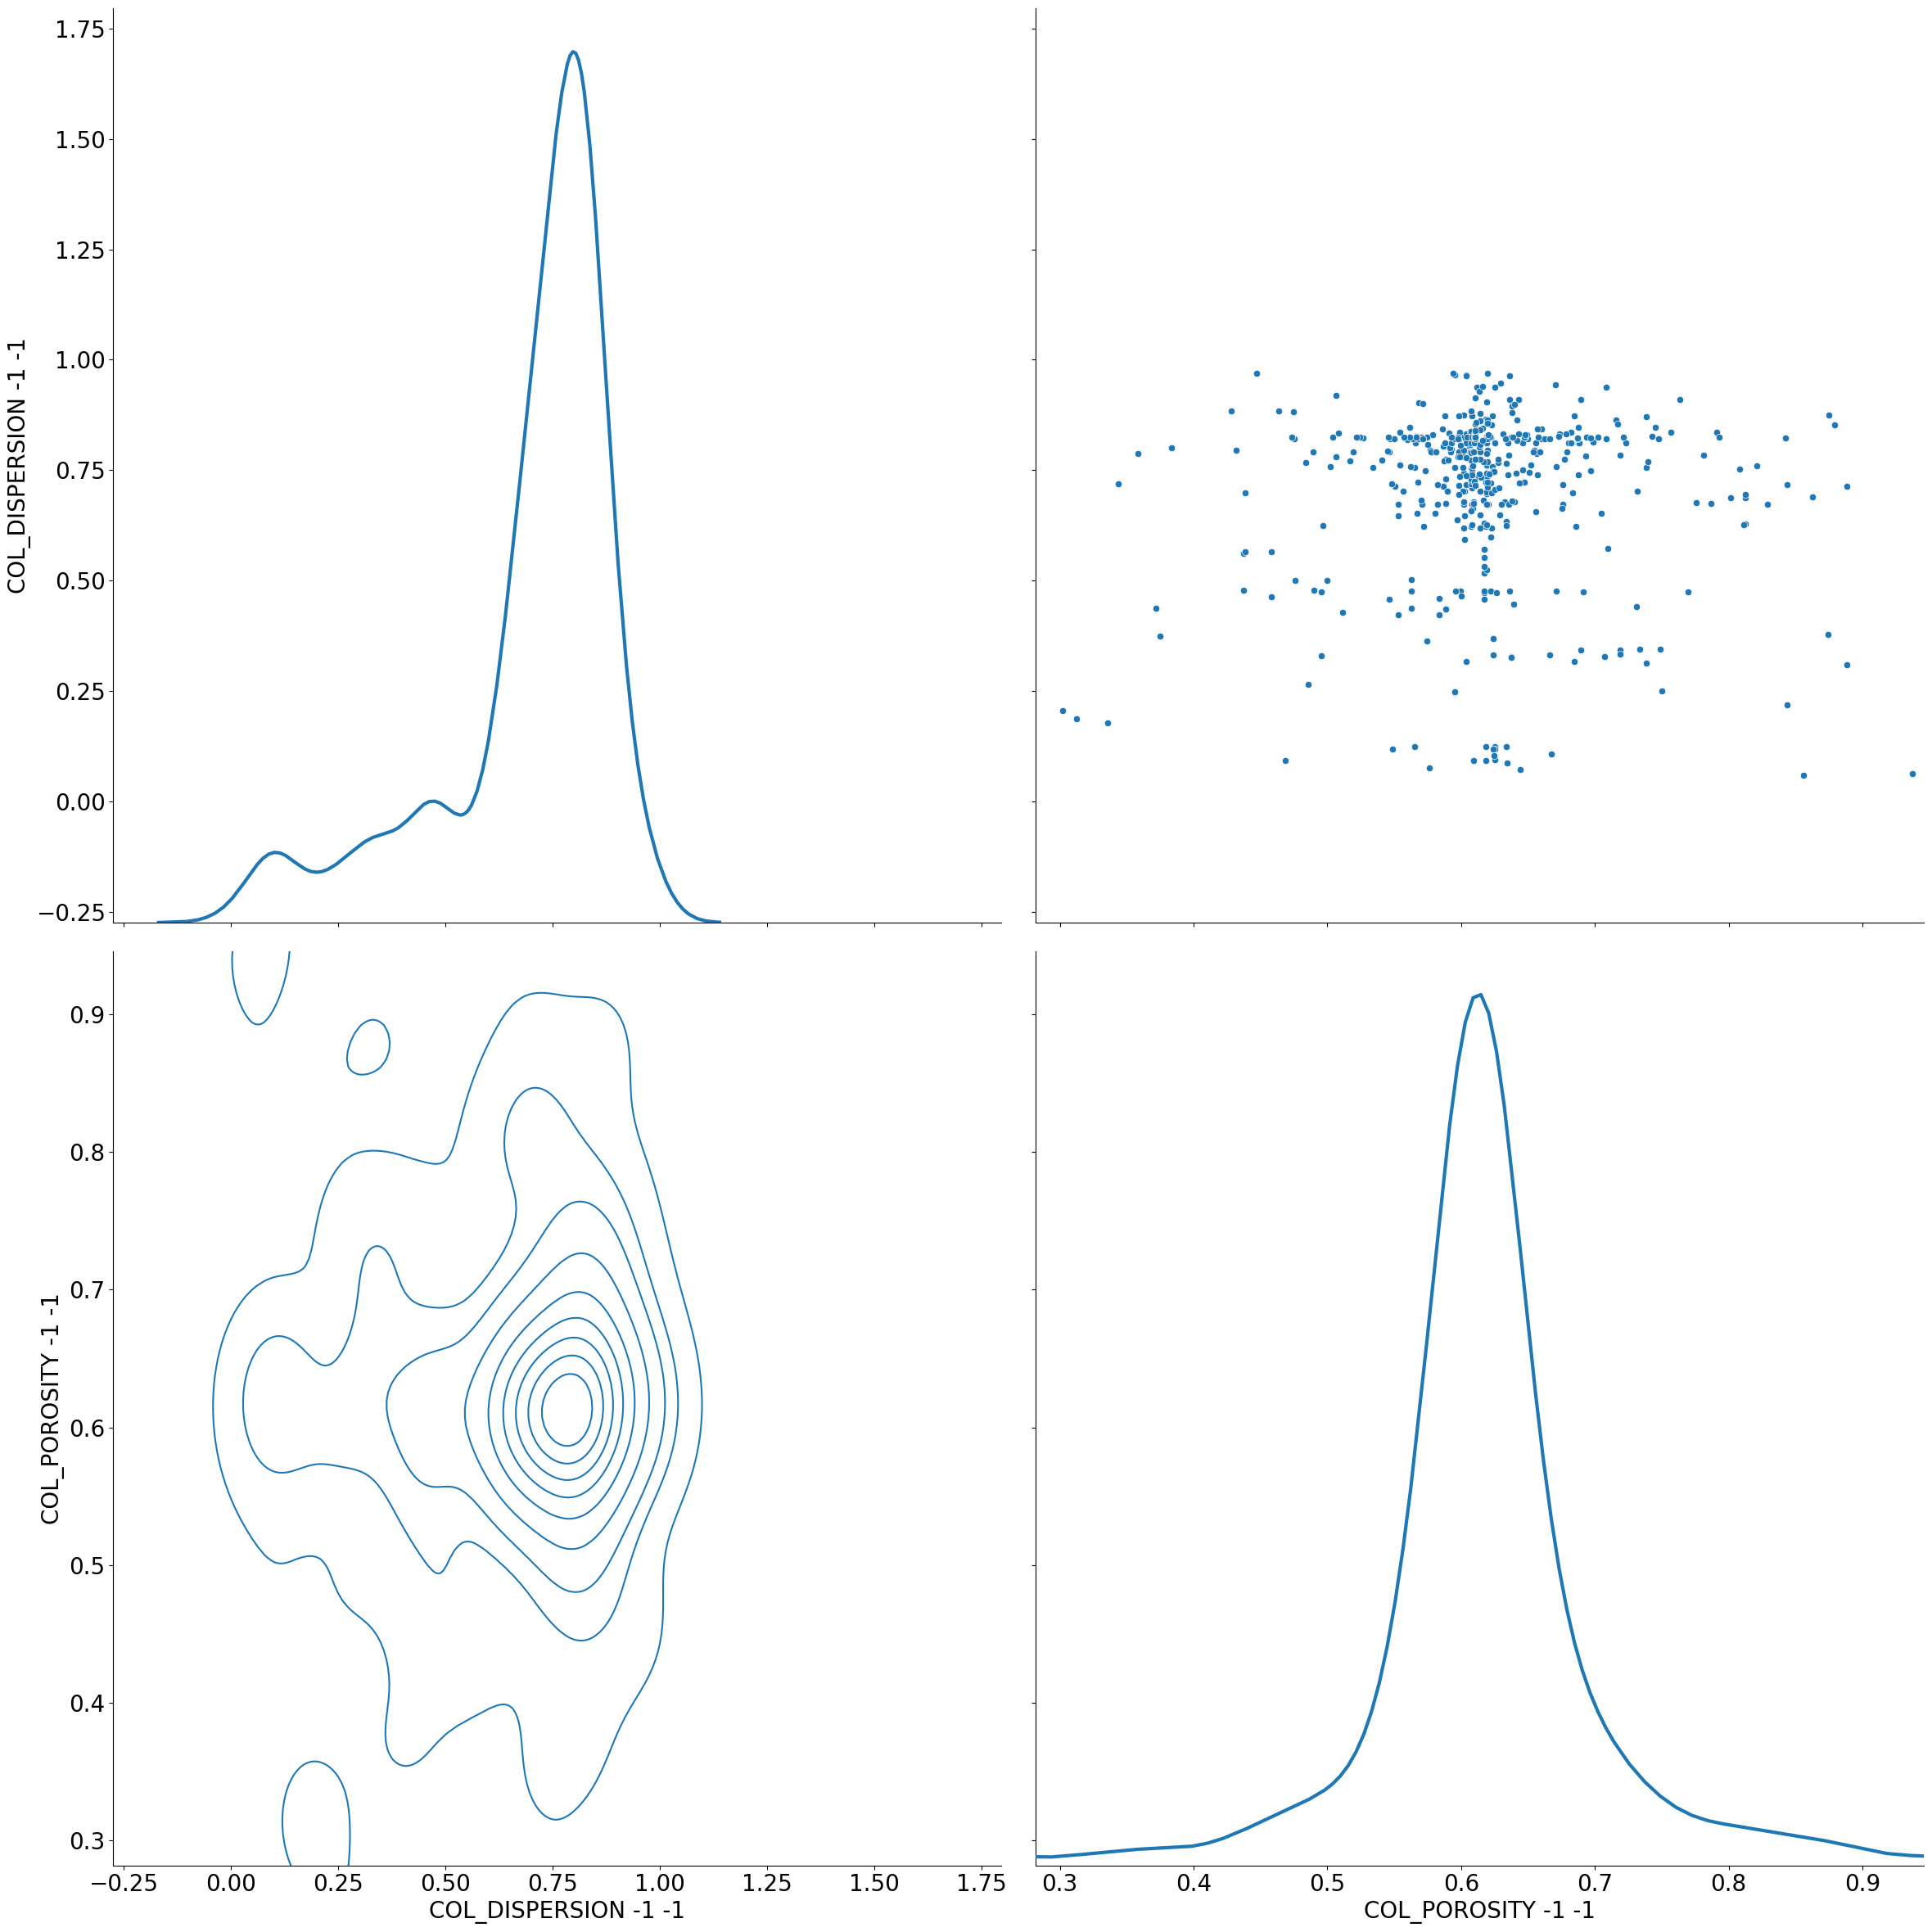

Corner plot in original space


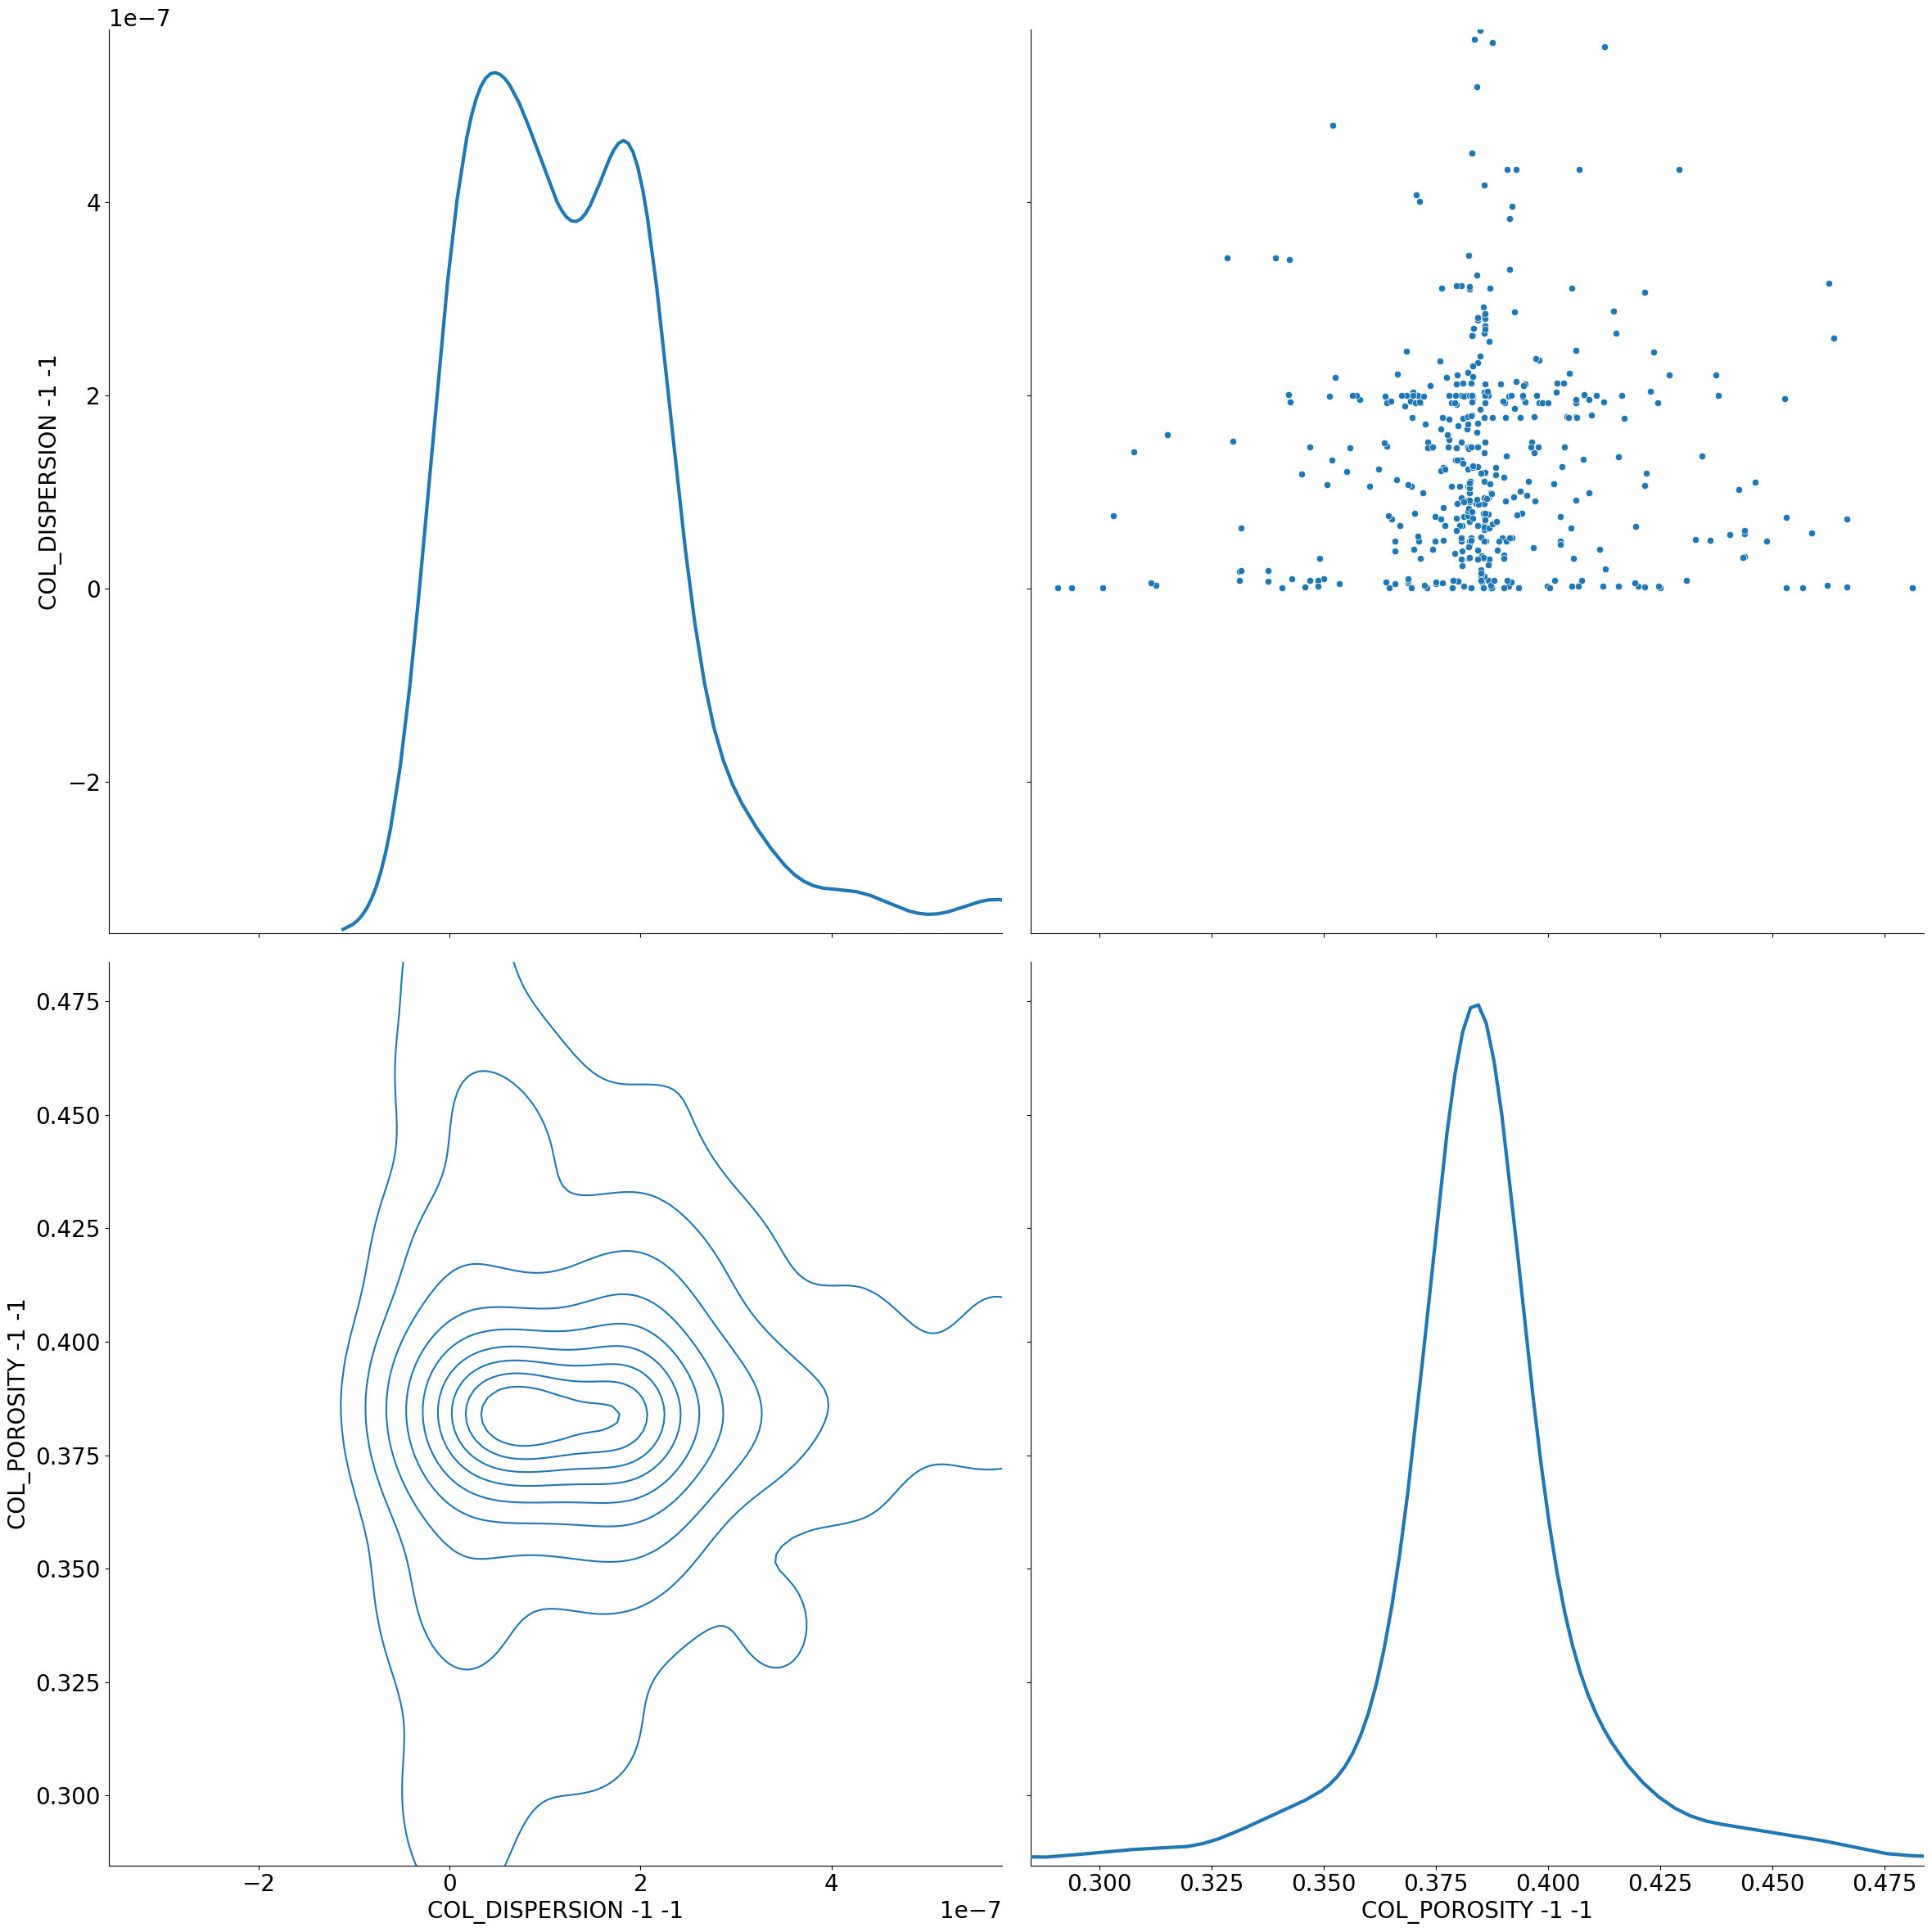

In [21]:
match.plot_corner()

Best item 73ad670a019e36e7713322d56f7fdf68 for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,dextran_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE,RMSE
0,Sun Oct 30 21:29:49 2022,73ad670a019e36e7713322d56f7fdf68,GRAD,4.739914,2.000000e-07,0.384315,1.812666e-26,1.812666e-26,1.812666e-26,1.812666e-26,1.812666e-26,6.299376e-15


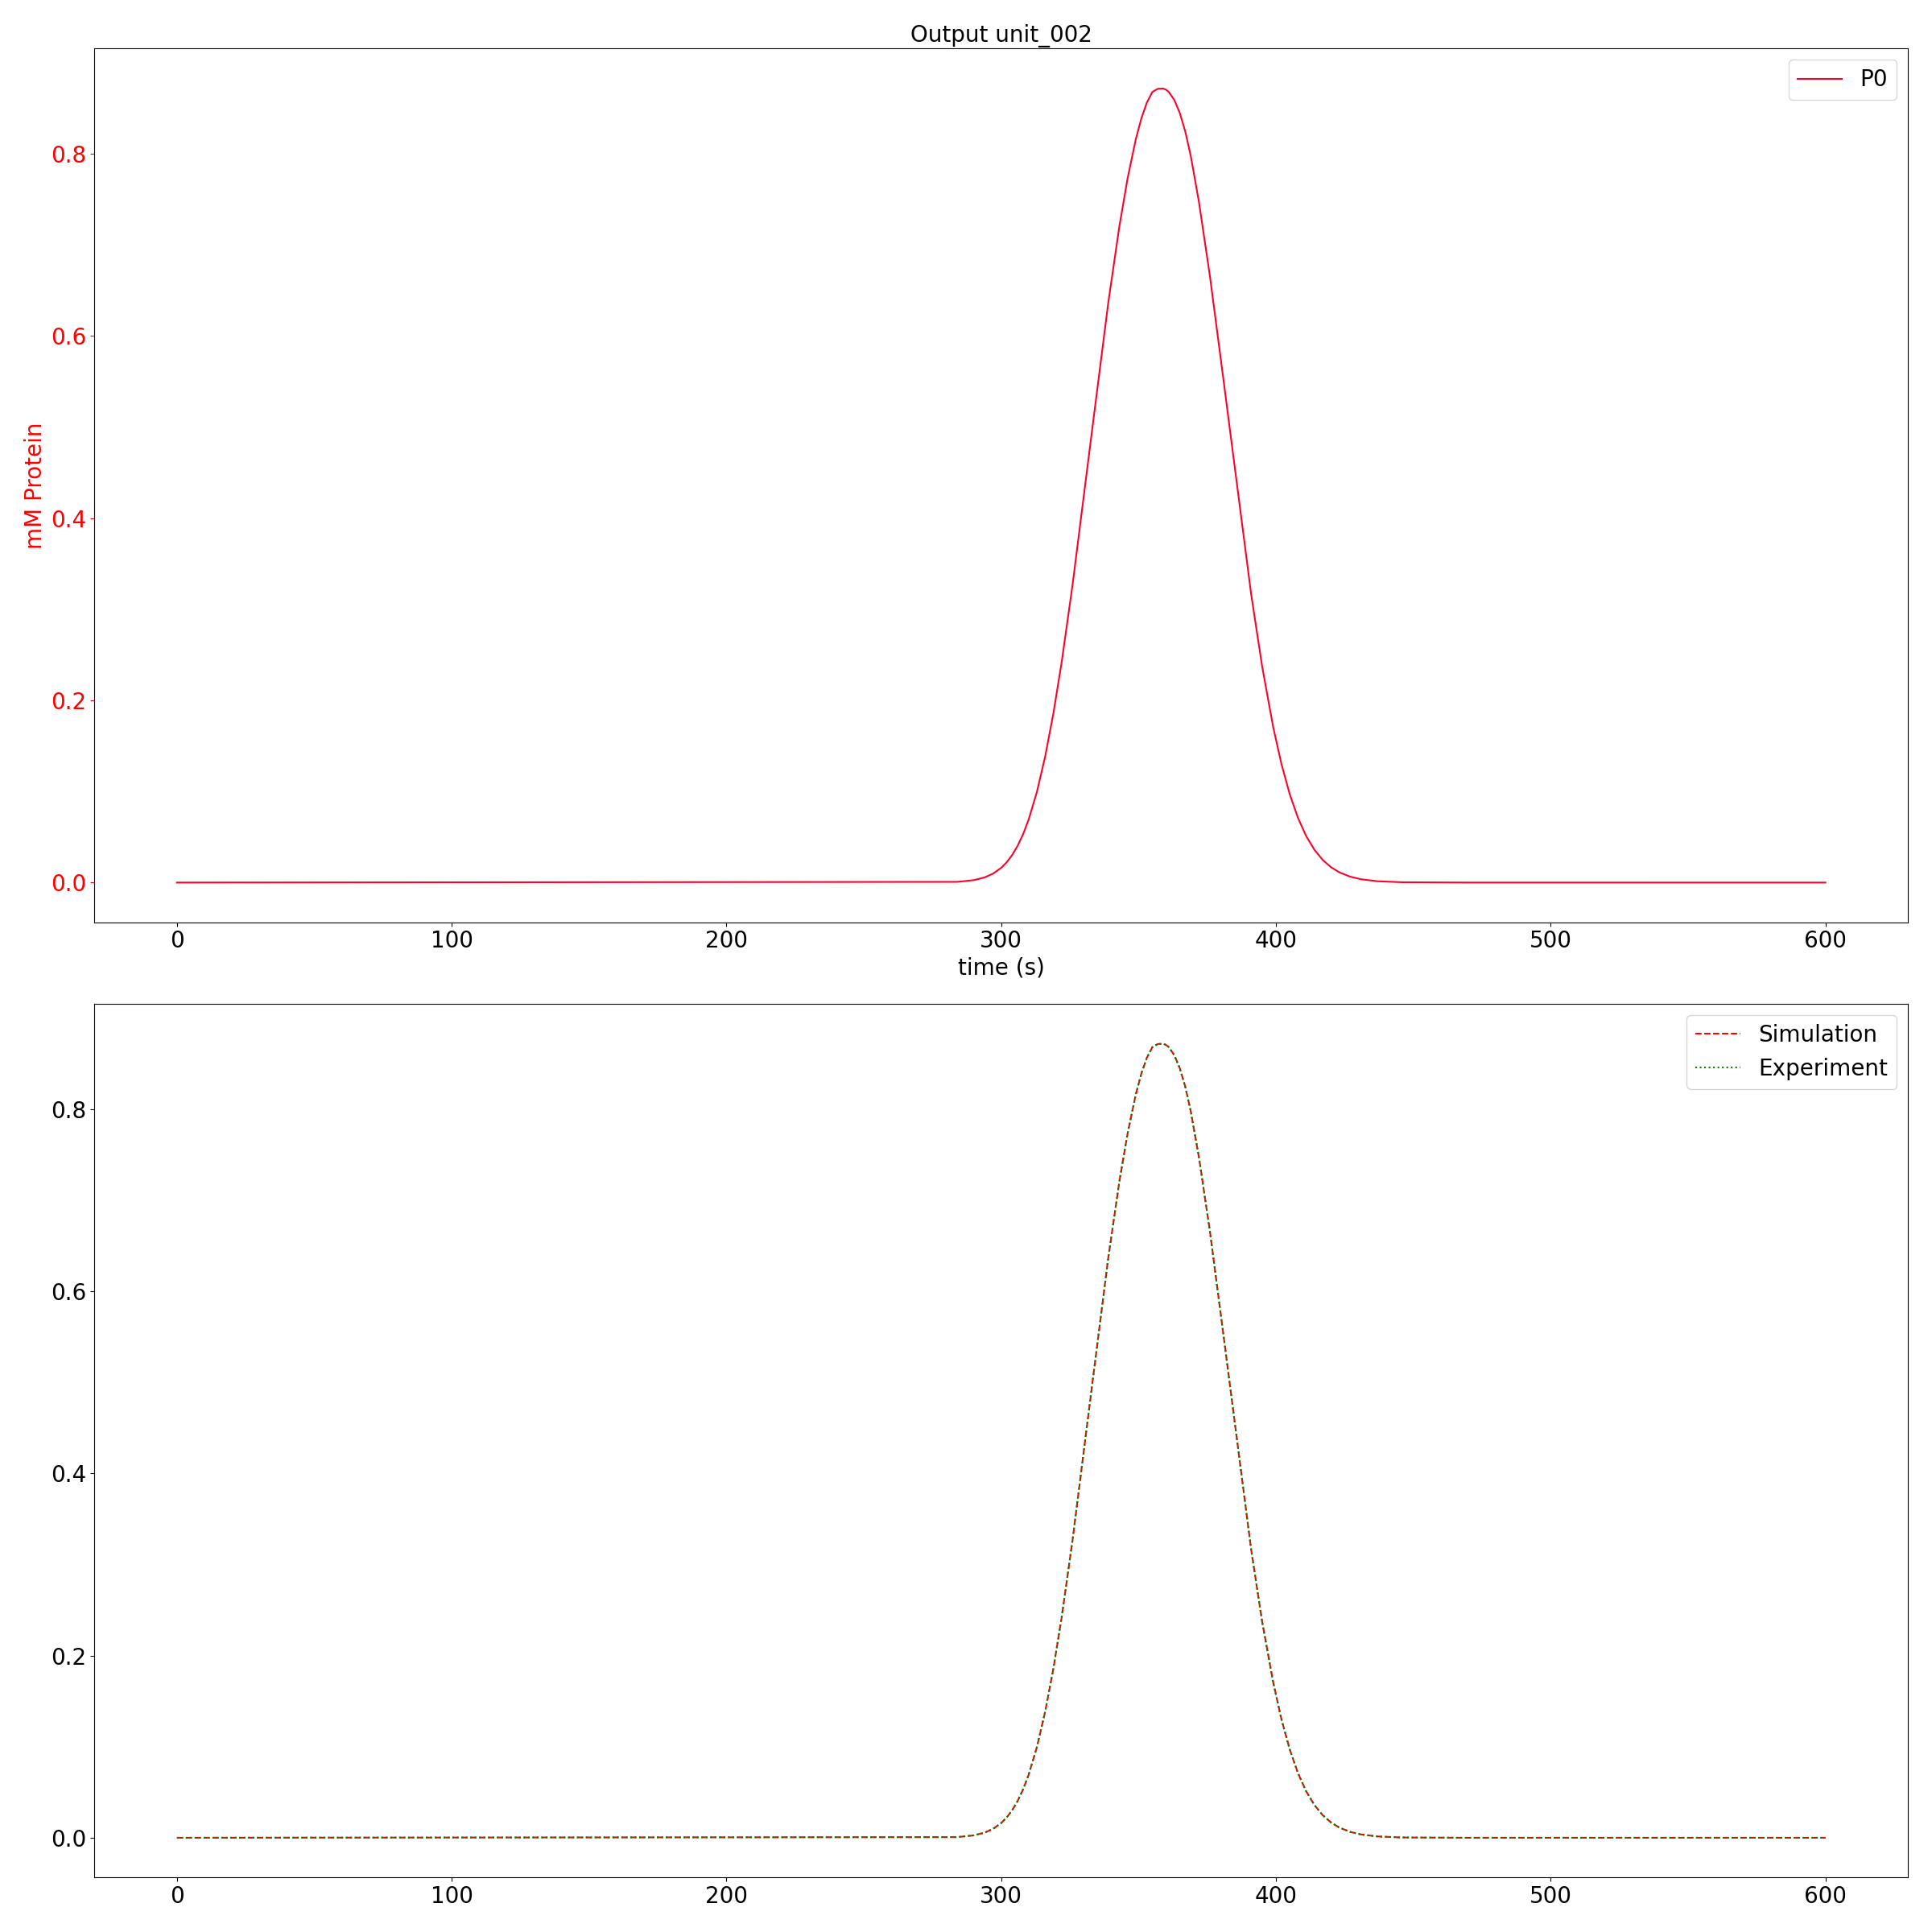

In [22]:
match.plot_best()